# Data Prepration

In [ ]:
import pandas as pd

def load_and_combine_data(file_paths,save_path):
    """
    Load and combine multiple CSV files containing date_time and load columns.

    Parameters:
    file_paths (list): List of file paths to CSV files.

    Returns:
    pd.DataFrame: Combined DataFrame with sorted date_time.
    """
    # Load and combine data
    data_frames = [pd.read_csv(file, parse_dates=['date_time']) for file in file_paths]
    combined_df = pd.concat(data_frames, ignore_index=True)

    # Ensure data is sorted by date_time
    combined_df = combined_df.sort_values(by='date_time')

    combined_df.to_csv(save_path, index=False)
    print(f"Combined data saved to {save_path}")

    print(f"Combined Data Shape: {combined_df.shape}")
    print(combined_df.head())
    return combined_df



In [ ]:
file_paths = [
    '/content/2025-03-01.csv','/content/2025-03-02.csv','/content/2025-03-03.csv','/content/2025-03-04.csv','/content/2025-03-05.csv',
    '/content/2025-03-06.csv','/content/2025-03-07.csv','/content/2025-03-08.csv','/content/2025-03-09.csv','/content/2025-03-10.csv',
    '/content/2025-03-11.csv','/content/2025-03-12.csv','/content/2025-03-13.csv','/content/2025-03-14.csv','/content/2025-03-15.csv',
    '/content/2025-03-16.csv','/content/2025-03-17.csv','/content/2025-03-18.csv','/content/2025-03-19.csv','/content/2025-03-20.csv',
    '/content/2025-03-21.csv','/content/2025-03-22.csv','/content/2025-03-23.csv','/content/2025-03-24.csv','/content/2025-03-25_sim.csv',
    '/content/2025-03-26_sim.csv','/content/2025-03-27_sim.csv','/content/2025-03-28_sim.csv','/content/2025-03-29_sim.csv']

combined_data = load_and_combine_data(file_paths,'/content/combined_data.csv')

Combined data saved to /content/combined_data.csv
Combined Data Shape: (2784, 2)
            date_time          load
0 2025-03-01 00:00:00  11432.431510
1 2025-03-01 00:15:00  11842.011393
2 2025-03-01 00:30:00  11806.792383
3 2025-03-01 00:45:00  11722.334831
4 2025-03-01 01:00:00  11472.657487


In [ ]:
import pandas as pd
import numpy as np

# Load the combined data
data = pd.read_csv('/content/combined_data.csv')

### Step 1: Check for Missing Values ###
print("Checking for missing values:")
missing_values = data.isnull().sum()
print(missing_values)

# If there are missing values, you can either drop or fill them
data = data.dropna()  # Remove missing values
# Alternatively, you can fill missing values with the mean or other strategies
# data['load'].fillna(data['load'].mean(), inplace=True)

### Step 2: Check for Duplicates ###
print("\nChecking for duplicates:")
duplicate_count = data.duplicated().sum()
print(f"Number of Duplicates: {duplicate_count}")

# Remove duplicates if any
data = data.drop_duplicates()

### Step 3: Check for Outliers Using IQR ###
print("\nDetecting Outliers using IQR Method:")
Q1 = data['load'].quantile(0.25)
Q3 = data['load'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['load'] < lower_bound) | (data['load'] > upper_bound)]
print(f"Number of Outliers Detected: {len(outliers)}")

# Optionally remove outliers
data_cleaned = data[(data['load'] >= lower_bound) & (data['load'] <= upper_bound)]

# Save the cleaned data
data_cleaned.to_csv('/content/cleaned_data.csv', index=False)
print("Data cleaning completed and saved as cleaned_data.csv")


Checking for missing values:
date_time    0
load         0
dtype: int64

Checking for duplicates:
Number of Duplicates: 0

Detecting Outliers using IQR Method:
Number of Outliers Detected: 0
Data cleaning completed and saved as cleaned_data.csv


# Feature engineering


In [ ]:
import pandas as pd
import numpy as np

# Load the cleaned data
file_path = "/content/cleaned_data.csv"
df = pd.read_csv(file_path, parse_dates=['date_time'])

# Extract time-based features
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['day_of_month'] = df['date_time'].dt.day
df['month'] = df['date_time'].dt.month

# Add cyclic features for time representation (sin/cos transformation)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Create lag features (previous hour & previous day at the same time)
df['load_lag_1h'] = df['load'].shift(1)
df['load_lag_24h'] = df['load'].shift(96)  # Assuming 96 blocks per day (15-min intervals)

# Compute rolling averages
df['rolling_mean_3h'] = df['load'].rolling(window=12).mean()  # 3-hour moving average
df['rolling_mean_6h'] = df['load'].rolling(window=24).mean()  # 6-hour moving average

# Drop rows with NaN values due to shifting/rolling operations
df.dropna(inplace=True)

# Save the processed dataset
output_path = "/content/engineered_data.csv"
df.to_csv(output_path, index=False)

print(f"Feature engineering completed and saved as {output_path}")


Feature engineering completed and saved as /content/engineered_data.csv


# Scaling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the engineered data
file_path = "/content/engineered_data.csv"
df = pd.read_csv(file_path)

# Separate features and target
X = df.drop(columns=['load', 'date_time'])  # Ensure 'date_time' is excluded
y = df['load'].values.reshape(-1, 1)

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the data
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Convert to DataFrames for easy saving
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_scaled_df = pd.DataFrame(y_scaled, columns=['load'])

# Save to CSV
X_scaled_df.to_csv("/content/X_scaled.csv", index=False)
y_scaled_df.to_csv("/content/y_scaled.csv", index=False)

# Save scalers for future inverse scaling
joblib.dump(scaler_X, '/content/scaler_X.pkl')
joblib.dump(scaler_y, '/content/scaler_y.pkl')

print("Data scaling completed and saved.")


Data scaling completed and saved.


# Train-Test split


In [ ]:
import pandas as pd

# Load the data
X_scaled = pd.read_csv('/content/X_scaled.csv')
y_scaled = pd.read_csv('/content/y_scaled.csv')
engineered_data = pd.read_csv('/content/engineered_data.csv', parse_dates=['date_time'])

# Ensure the order is maintained
X_scaled['date_time'] = engineered_data['date_time']
y_scaled['date_time'] = engineered_data['date_time']

# Perform the split
X_train = X_scaled[(X_scaled['date_time'] >= '2025-03-01 00:00:00') & (X_scaled['date_time'] <= '2025-03-24 23:59:59')].drop('date_time', axis=1)
X_test = X_scaled[(X_scaled['date_time'] >= '2025-03-25 00:00:00') & (X_scaled['date_time'] <= '2025-03-29 23:59:59')].drop('date_time', axis=1)

y_train = y_scaled[(y_scaled['date_time'] >= '2025-03-01 00:00:00') & (y_scaled['date_time'] <= '2025-03-24 23:59:59')].drop('date_time', axis=1)
y_test = y_scaled[(y_scaled['date_time'] >= '2025-03-25 00:00:00') & (y_scaled['date_time'] <= '2025-03-29 23:59:59')].drop('date_time', axis=1)

# Save the results
X_train.to_csv('/content/X_train.csv', index=False)
X_test.to_csv('/content/X_test.csv', index=False)
y_train.to_csv('/content/y_train.csv', index=False)
y_test.to_csv('/content/y_test.csv', index=False)

print("Train-Test Split Completed.")
print(f"Training Data Shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Data Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Train-Test Split Completed.
Training Data Shape: X_train: (2208, 12), y_train: (2208, 1)
Testing Data Shape: X_test: (480, 12), y_test: (480, 1)


# GRU model


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Check and delete any existing model
model_path = '/content/gru_model.h5'
if os.path.exists(model_path):
    os.remove(model_path)
    print("Previous model deleted successfully.")
else:
    print("No existing model found. Proceeding with a fresh start.")

# Load the data
X_train = pd.read_csv('/content/X_train.csv').values
y_train = pd.read_csv('/content/y_train.csv').values

# Reshape the data to match GRU input format (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Validate input shape
input_shape = (X_train.shape[1], X_train.shape[2])
print(f"Input Shape: {input_shape}")

# Define the GRU model
def create_gru_model(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    return model

# Create and compile the model
model = create_gru_model(input_shape)
model.summary()

# Train the model without EarlyStopping
print("Starting model training...")
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)

# Save the trained model
model.save(model_path)
print(f"Model trained and saved at {model_path}")


No existing model found. Proceeding with a fresh start.
Input Shape: (1, 12)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,929 (97.38 KB)

 Trainable params: 24,929 (97.38 KB)

 Non-trainable params: 0 (0.00 B)

Starting model training...
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.1390 - mae: 0.2946 - mape: 61.3528 - val_loss: 0.0140 - val_mae: 0.1002 - val_mape: 635785.5000
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0137 - mae: 0.0909 - mape: 23.8882 - val_loss: 0.0034 - val_mae: 0.0449 - val_mape: 285051.4375
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0707 - mape: 16.5220 - val_loss: 0.0033 - val_mae: 0.0441 - val_mape: 304624.0312
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0688 - mape: 16.1330 - val_loss: 0.0025 - val_mae: 0.0401 - val_mape: 276151.5938
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0648 - mape: 15.2557 - val_loss: 0.0024 - val_mae: 0.0401 - val_mape: 285806.7188
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060 - mae: 0.0598 - mape: 14.1072 - val_loss: 0.0026 - val_mae: 0.0388 - val_mape: 276880.0312
Epoch 7/100
56/56 ━━━━━━━━━━━

Model trained and saved at /content/gru_model.h5


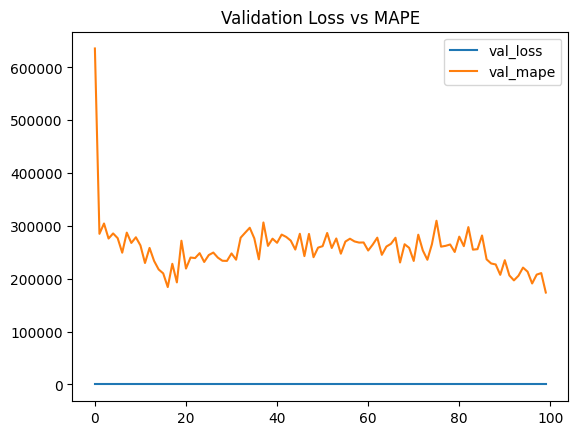

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_mape'], label='val_mape')
plt.legend()
plt.title("Validation Loss vs MAPE")
plt.show()


# Predictions

In [ ]:
import pandas as pd

# List of file paths
file_paths = [
    '/content/2025-03-25.csv',
    '/content/2025-03-26.csv',
    '/content/2025-03-27.csv',
    '/content/2025-03-28.csv',
    '/content/2025-03-29.csv'
]

# Load and concatenate the CSV files
combined_df = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)

# Save to a new CSV file
combined_df.to_csv('/content/combined_actual_2025_03_25_to_29.csv', index=False)

print("✅ Combined file saved as '/content/combined_actual_2025_03_25_to_29.csv'")


✅ Combined file saved as '/content/combined_actual_2025_03_25_to_29.csv'


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the scaled test data
X_test = pd.read_csv('/content/X_test.csv').values

# Reshape to match the input shape for the GRU model (batch_size, time_steps, num_features)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(f"Reshaped X_test shape: {X_test.shape}")

# Load the trained GRU model using custom_objects to recognize mse
model_path = '/content/gru_model.h5'
model = tf.keras.models.load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
print("Model Loaded Successfully.")

# Perform predictions
print("Performing Predictions...")
pred_scaled = model.predict(X_test)

# Load the scaler and inverse transform predictions to the original scale
import joblib
scaler_y = joblib.load('/content/scaler_y.pkl')
pred_rescaled = scaler_y.inverse_transform(pred_scaled)

# Save predictions with timestamps
actual_df = pd.read_csv('/content/combined_actual_2025_03_25_to_29.csv', parse_dates=['date_time'])
prediction_df = pd.DataFrame({'date_time': actual_df['date_time'], 'predicted_load': pred_rescaled.flatten()})
prediction_df.to_csv('/content/prediction_results.csv', index=False)

print("Predictions saved to prediction_results.csv")


Reshaped X_test shape: (480, 1, 12)
Model Loaded Successfully.
Performing Predictions...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
Predictions saved to prediction_results.csv


# saving prediction date_wise


In [ ]:
import pandas as pd
import os

# Load predictions
pred_df = pd.read_csv('/content/prediction_results.csv', parse_dates=['date_time'])

# Ensure the predictions folder exists
os.makedirs('/content/predictions', exist_ok=True)

# Loop over dates from 25 to 29 March
for day in range(25, 30):
    date_str = f'2025-03-{day:02d}'
    daily_df = pred_df[pred_df['date_time'].dt.date == pd.to_datetime(date_str).date()]

    # Save to individual CSV
    output_path = f'/content/predictions/{date_str}_predicted.csv'
    daily_df.to_csv(output_path, index=False)

print("✅ Predictions split and saved by date in '/content/predictions/' folder.")


✅ Predictions split and saved by date in '/content/predictions/' folder.


# Visualization

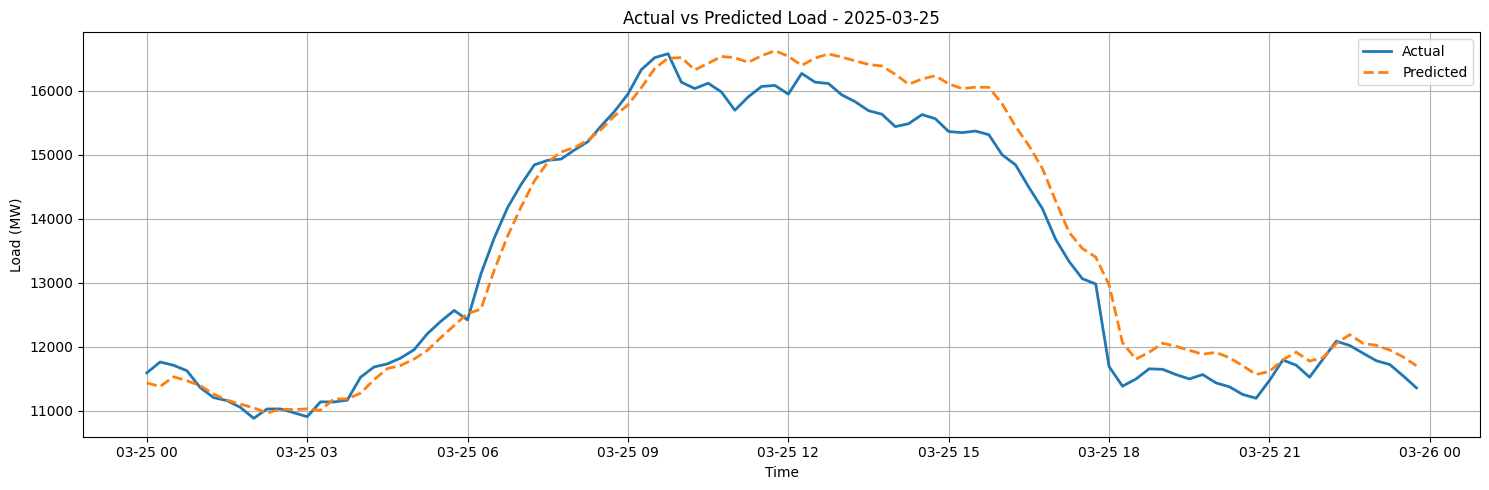

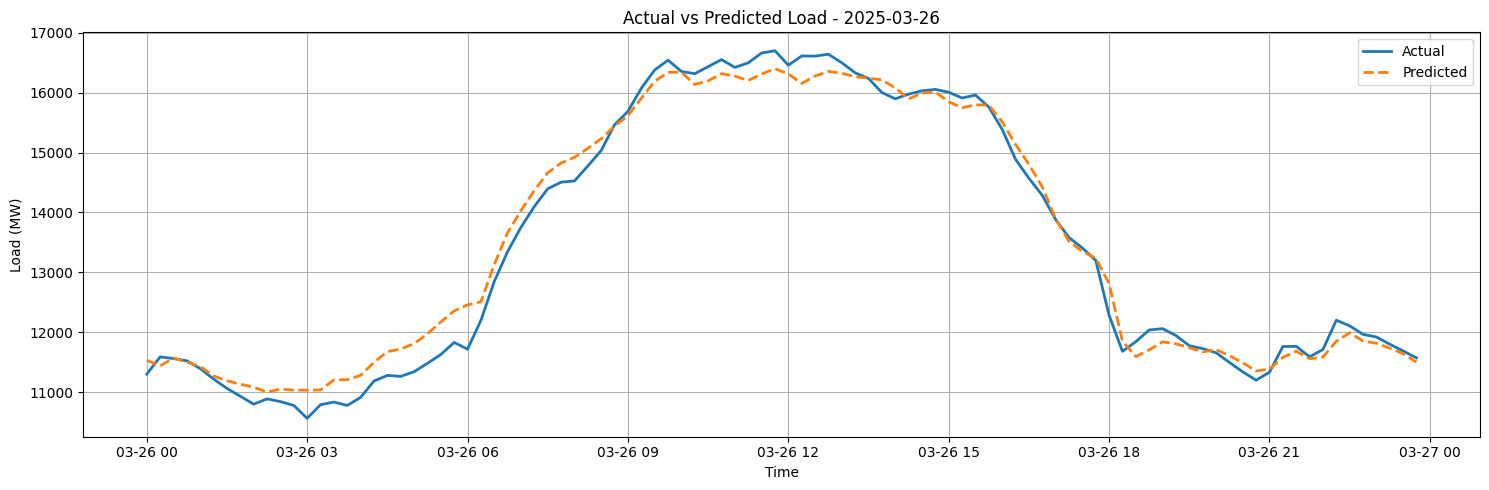

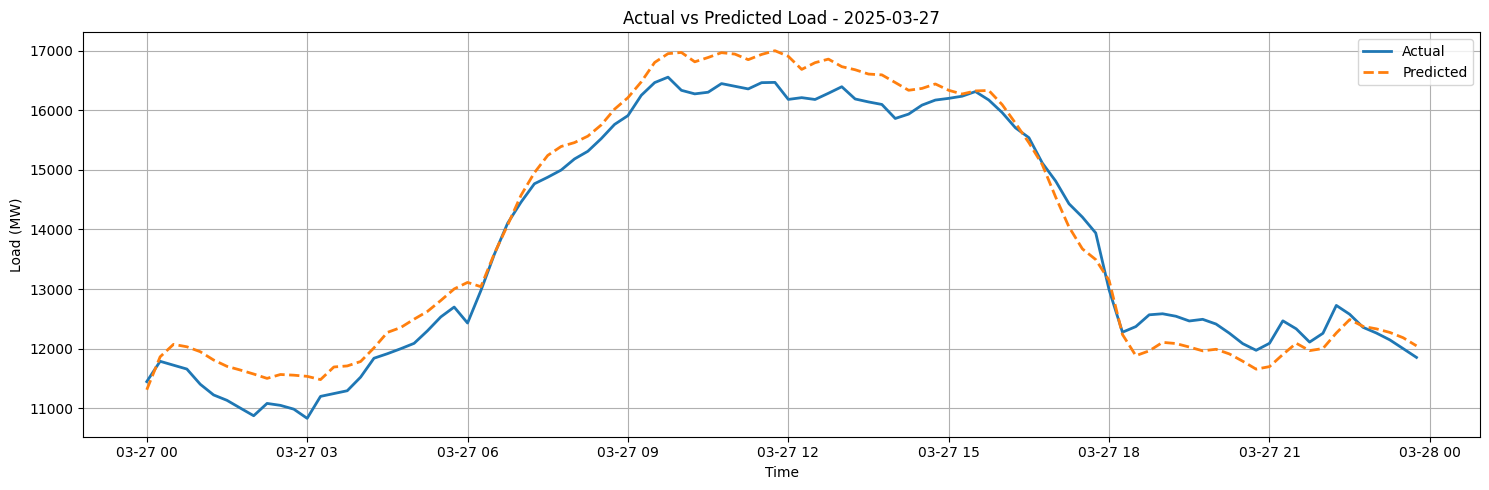

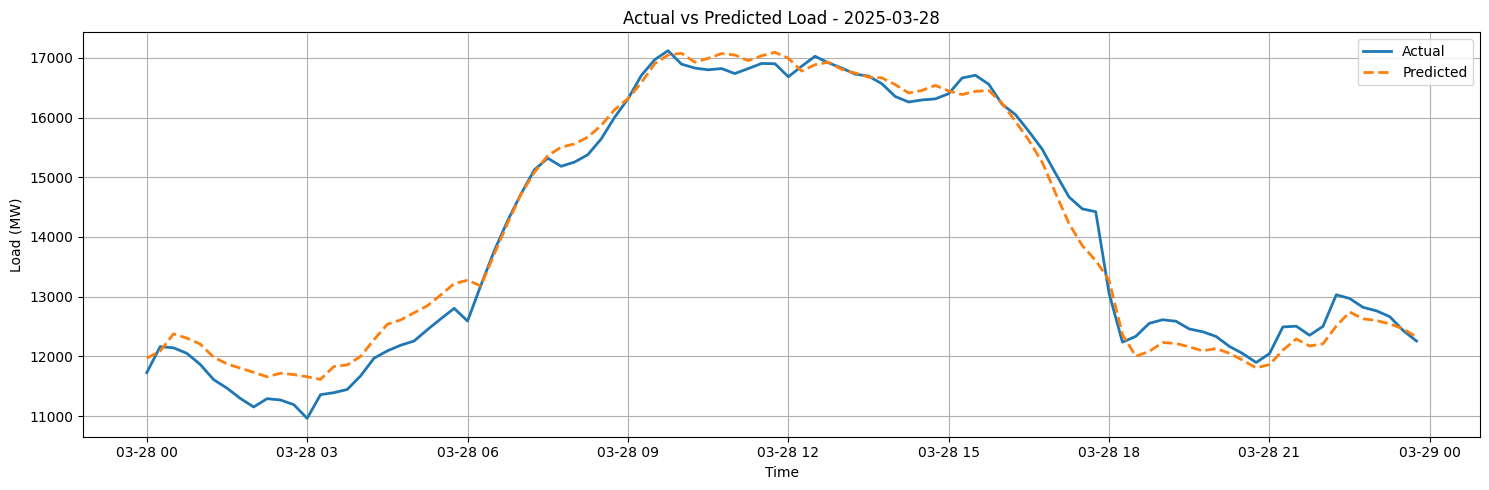

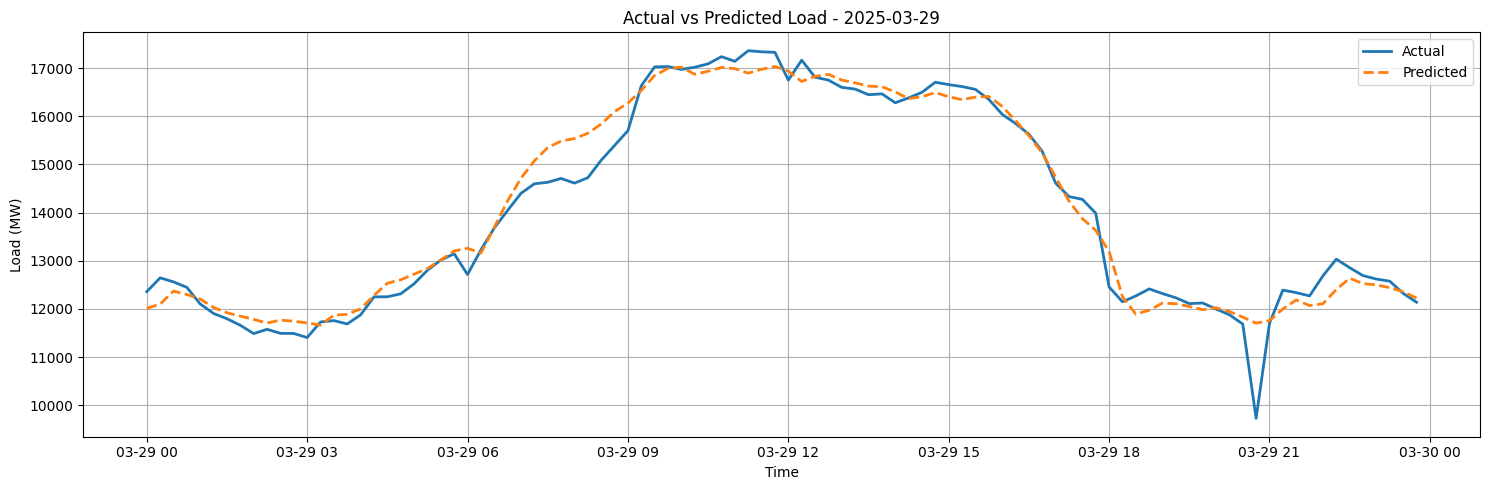

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dates to loop through
dates = [f"2025-03-{day:02d}" for day in range(25, 30)]

# Loop through each date
for date in dates:
    actual_path = f"/content/{date}.csv"
    predicted_path = f"/content/predictions/{date}_predicted.csv"

    # Load actual and predicted data
    actual_df = pd.read_csv(actual_path, parse_dates=['date_time'])
    predicted_df = pd.read_csv(predicted_path, parse_dates=['date_time'])

    # Extract load values
    actual = actual_df['load'].values
    predicted = predicted_df['predicted_load'].values

    # Plot actual vs predicted
    plt.figure(figsize=(15, 5))
    time_labels = pd.to_datetime(actual_df['date_time'])
    plt.plot(time_labels, actual, label='Actual', linewidth=2)
    plt.plot(time_labels, predicted, label='Predicted', linestyle='--', linewidth=2)
    plt.title(f"Actual vs Predicted Load - {date}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Metrics


📊 Forecast Metrics:

Date                MAE       RMSE   MAPE (%)
----------------------------------------------
2025-03-25       340.09     423.60       2.48
2025-03-26       206.86     254.52       1.61
2025-03-27       349.51     397.28       2.61
2025-03-28       247.04     301.85       1.89
2025-03-29       256.87     375.92       1.91


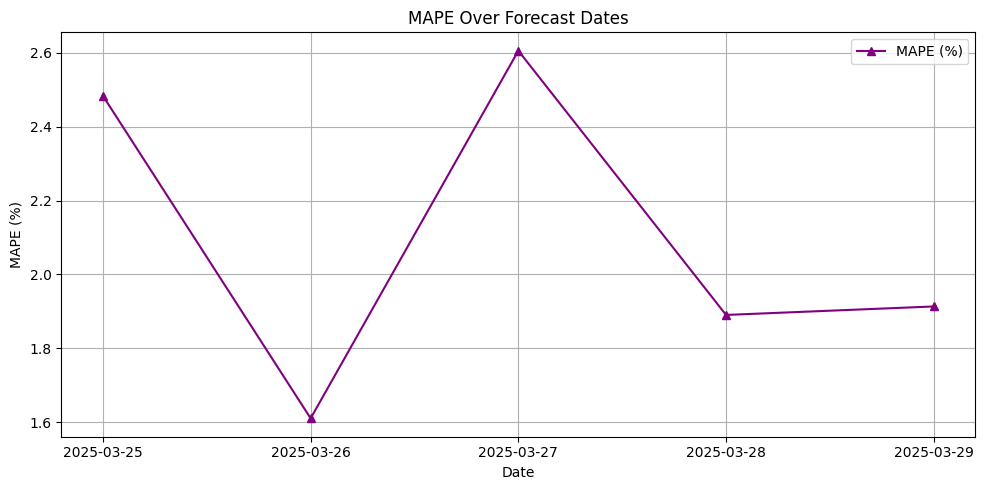

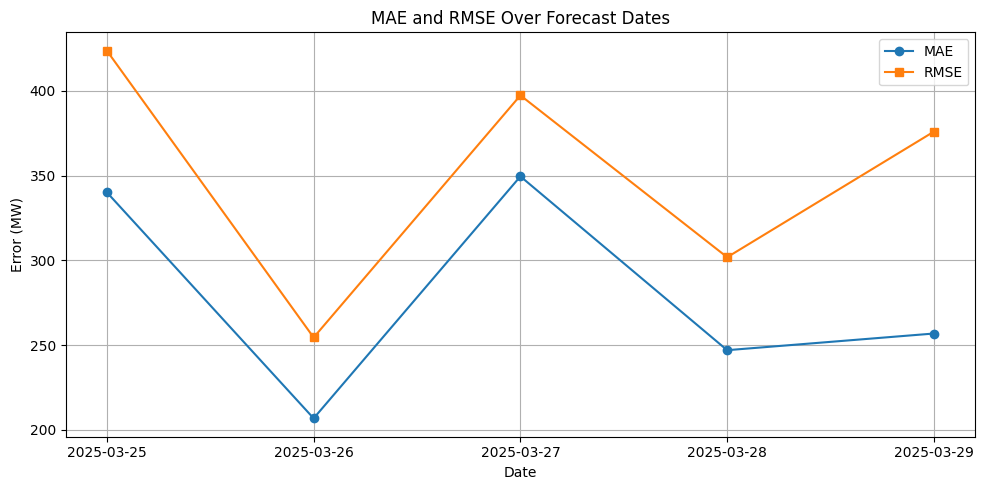

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Helper function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize lists for storing metrics
dates = [f"2025-03-{day:02d}" for day in range(25, 30)]
maes, rmses, mapes = [], [], []

# Calculate metrics for each date
print("📊 Forecast Metrics:\n")
print("{:<12} {:>10} {:>10} {:>10}".format("Date", "MAE", "RMSE", "MAPE (%)"))
print("-" * 46)

for date in dates:
    actual_path = f"/content/{date}.csv"
    predicted_path = f"/content/predictions/{date}_predicted.csv"

    actual_df = pd.read_csv(actual_path)
    predicted_df = pd.read_csv(predicted_path)

    actual = actual_df['load'].values
    predicted = predicted_df['predicted_load'].values

    # Metrics
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)

    maes.append(mae)
    rmses.append(rmse)
    mapes.append(mape)

    print(f"{date:<12} {mae:10.2f} {rmse:10.2f} {mape:10.2f}")

# Plot MAPE
plt.figure(figsize=(10, 5))
plt.plot(dates, mapes, marker='^', color='purple', label='MAPE (%)')
plt.title("MAPE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAE and RMSE
plt.figure(figsize=(10, 5))
plt.plot(dates, maes, marker='o', label='MAE')
plt.plot(dates, rmses, marker='s', label='RMSE')
plt.title("MAE and RMSE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
